# Hyperparameteroptimization

Steps:
   1. Definition of the data
   2. Definition of the hyperparameter space
   3. Loop over all different combinations of the hyperparamter space
       1. Define the model with the hyperparameters
       2. Optimize model (learning phase)
       3. Evaluate model and store metric with the parameters
 

## 0. Imports

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import itertools

from mpl_toolkits import mplot3d


%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import time, sys
from IPython.display import clear_output

## 1. Definition of Data

In [60]:
NORMAL_FILE_PATH = "ecg/normal"
ABNORMAL_FILE_PATH = "ecg/abnormal"

SPLIT_RATIO = 0.8

# Load the .0 and .1 files as integer and with max 75 elements per entry.
normal_data = np.array([[np.loadtxt(entry, dtype=int, usecols=1, max_rows=75)] for entry in os.scandir(NORMAL_FILE_PATH) if not entry.name.endswith(".ann")], dtype=object)
abnormal_data = np.array([[np.loadtxt(entry, dtype=int, usecols=1, max_rows=75)] for entry in os.scandir(ABNORMAL_FILE_PATH) if not entry.name.endswith(".ann")], dtype=object)

# Pad the with zeroes, so that each entry has 75 data points. Also append the class number at the end (0=normal, 1=abnormal).
normal_data = np.array([np.append(np.pad(d[0], pad_width=(0, 75 - len(d[0]))), 0) for d in normal_data])
abnormal_data = np.array([np.append(np.pad(d[0], pad_width=(0, 75 - len(d[0]))), 1) for d in abnormal_data])

# Combine the normal and abnormal data and shuffle the whole dataset.
combined_data = np.concatenate((normal_data, abnormal_data))
np.random.shuffle(combined_data)

# Split into training and validation sets.
X_train = torch.Tensor(combined_data[:int(len(combined_data) * SPLIT_RATIO), 0:75])
X_test = torch.Tensor(combined_data[int(len(combined_data) * SPLIT_RATIO):, 0:75])
Y_train = torch.Tensor(combined_data[:int(len(combined_data) * SPLIT_RATIO), 75:])
Y_test = torch.Tensor(combined_data[int(len(combined_data) * SPLIT_RATIO):, 75:])

## 2. Definition of Hyperparameter space

In [61]:
#from interval import Interval



hyperparameters = {
#    "learning_rate" : Interval(0.00001, 0.01),
    "learning_rate" : [0.00001, 0.01],
    "epochs" : [0, 300]
}

print("Number of hyperparameters: ", len(hyperparameters))

Number of hyperparameters:  2


## 3. Loop over combinations

In [ ]:
def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

number_per_dimension = 40

list_of_values = []

for k in hyperparameters.keys():
    values = []
    
    lower, upper = hyperparameters[k][0], hyperparameters[k][1]
    
    for j in range(number_per_dimension):
        values.append(lower+((upper-lower)/(2*number_per_dimension))+j*((upper-lower)/(number_per_dimension)))

    list_of_values.append(values)
    
print(list_of_values)

results_accuracy = []
results_loss = []

all_combinations = itertools.product(*list_of_values)


number_combinations = 1
for i in range(len(list_of_values)):
    number_combinations *= len(list_of_values[i])


count = 0
for combination in all_combinations:
    #print("Current combination: ",combination)
    
    
    learning_rate = combination[0]
    epochs = combination[1]
    
    # Create neural network with 3 layers (75, 5, 1).
    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.fc1 = nn.Linear(75, 5)
            self.fc2 = nn.Linear(5, 1)

        def forward(self, x):
            x = self.fc1(x)
            x = F.relu(x)
            x = self.fc2(x)
            x = torch.sigmoid(x)
            return x

    # Set optimizer and loss function.
    n = Net()
    #optimizer = optim.RMSprop(n.parameters(), lr=0.001)
    optimizer = optim.RMSprop(n.parameters(), lr=learning_rate)
    loss_fn = torch.nn.BCELoss()
    #epochs = 300
    t_loss = []
    v_loss = []
    t_acc = []
    v_acc = []


    def avg(l):
        return sum(l) / len(l)

    # Training loop.
    for i in range(int(epochs)):
        n.train()
        y_pred_train = n(X_train)
        loss_train = loss_fn(y_pred_train, Y_train)
        y_pred_test = n(X_test)
        loss_test = loss_fn(y_pred_test, Y_test)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        n.eval()
        t_loss.append(loss_train.item())
        v_loss.append(loss_test.item())
        predictions_test = [round(i[0]) for i in y_pred_test.tolist()]
        accuracy_test = Y_test.tolist()
        acc_test = avg([1 - (abs(predictions_test[i] - accuracy_test[i][0])) for i in
                        range(len(accuracy_test))])
        predictions_train = [round(i[0]) for i in y_pred_train.tolist()]
        accuracy_train = Y_train.tolist()
        acc_train = avg([1 - (abs(predictions_train[i] - accuracy_train[i][0])) for i in
                         range(len(accuracy_train))])
        t_acc.append(acc_train)
        v_acc.append(acc_test)


    results_loss.append((combination ,min(v_loss)))
    results_accuracy.append((combination, min(v_acc)))
    
    percentage = count/number_combinations

    count+=1
    
    update_progress(percentage)
    
print("Resulting losses: ")
print(results_loss)


print("Resulting accuracy: ")
print(results_accuracy)

Progress: [####################] 99.4%


## 4. Plotting and Result

Highest Accuracy:  0.7
With hyperparameter combination:  (0.008876125, 251.25)


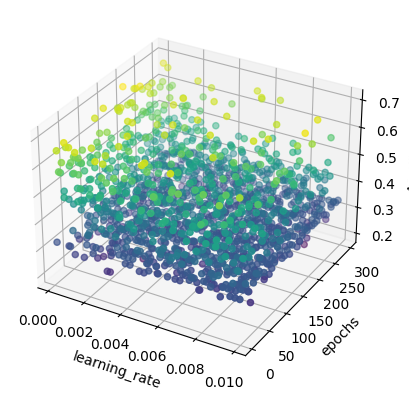

In [46]:
x_dim_vals = [x[0][0] for x in results_accuracy]
y_dim_vals = [x[0][1] for x in results_accuracy]

accuracies = [x[1] for x in results_accuracy]
losses = [x[1] for x in results_loss]

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(x_dim_vals, y_dim_vals, accuracies, c=accuracies);
ax.set_xlabel('learning_rate')
ax.set_ylabel('epochs')
ax.set_zlabel('Accuracy');
fig
print("Highest Accuracy: ", max(accuracies))
combi = -1
for i in results_accuracy:
    if i[1] - min(accuracies) < 10**(-5):
        combi = i[0]
print("With hyperparameter combination: ", combi)


Smallest Loss:  0.33168381452560425
With hyperparameter combination:  (0.0036313750000000005, 206.25)


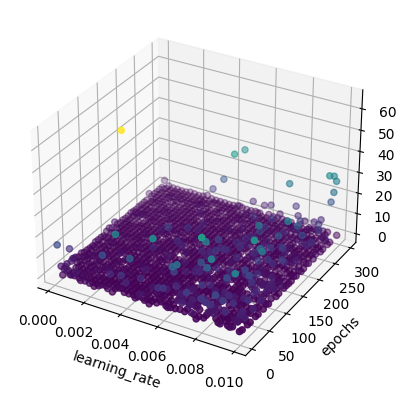

In [47]:

ax = plt.axes(projection='3d')
ax.scatter3D(x_dim_vals, y_dim_vals, losses, c=losses);
ax.set_xlabel('learning_rate')
ax.set_ylabel('epochs')
ax.set_zlabel('Accuracy');
fig
print("Smallest Loss: ", min(losses))
combi = -1
for i in results_loss:
    if i[1] - min(losses) < 10**(-5):
        combi = i[0]
print("With hyperparameter combination: ", combi)
